<a href="https://colab.research.google.com/github/i-moes/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Group 7

---



In [0]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/i-moes/TM10007_PROJECT.git

# Install packages
!pip install sklearn numpy matplotlib

In [0]:
# # General packages
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets as ds
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest

# Metrics
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score

# Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

pd.options.mode.chained_assignment = None  # default='warn'

import sys
import os
import pandas as pd
from sklearn.decomposition import PCA

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import multilabel_confusion_matrix



## Section 0: Functions

In [0]:


def preprocessing(data):
  '''
  '''

  # Extract labels from dataframe
  labels = data['label']
  # Drop column containing patient labels for imputation
  data = data.drop(columns=['label'])

  # Convert labels to binary label
  labels_bin = sklearn.preprocessing.label_binarize(labels, ['LGG','GBM'])
  labels_bin = [i[0] for i in labels_bin]

  ## Cleaning data from NaN, zero, #DIC/0! errors and inf values
  # Replace all zero values with NaN
  data.replace(0, np.nan, inplace=True)
  # Replace all zero division errors with NaN
  data.replace('#DIV/0!', np.nan, inplace=True)
  # Replace all inf values with NaN
  data.replace(np.inf, np.nan, inplace=True)
  # Remove column when >5% of values is NaN
  data.dropna(axis = 1, thresh=0.95*len(data.index), inplace=True)
  
  return data, labels_bin


def splitting_train_test(data, labels, size_test):
    '''
    Splitting the data and corresponding labels into a train and test set.

    Parameters
    ----------

    data : array-like, shape (n_samples, n_features)
        Data, where n_samples is the number of samples
        and n_features is the number of features.

    labels : array, shape = [n_samples]
        True binary labels

    size_test : array, shape = [size_test]
        Required part of data to be used for testing (0-1)

    Returns
    -------

    x_train : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.

    x_test : array-like, shape (n_samples, n_features)
        Testing data, where n_samples is the number of samples
        and n_features is the number of features.

    y_train : array, shape = [n_samples]
        True binary labels of train set

    y_test : array, shape = [n_samples]
        True binary labels of test set
    '''

    try:
        x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=size_test)
    except ValueError:
        print('Not enough subjects to split into train and test set.')
        sys.exit()

    # Convert labels of train and test set to array
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)

    return x_train, x_test, y_train, y_test


def train_pca(x_train, x_test, components=4):
    '''
    The  Principal component analysis (PCA) training function creates
    and fits the PCA to transform point data into
    based on an amount of prinicipal components.
    Returns the transformed point data.

    Parameters
    ----------

    x_train : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.

    x_test : array-like, shape (n_samples, n_features)
        Testing data, where n_samples is the number of samples
        and n_features is the number of features.

    components : integer
        Amount of used principal components.
        Default value is 4 principal components

    Returns
    -------

    x_train_trans : array-like, shape (n_samples, n_features)
        Transformed training data, where n_samples is the number of samples
        and n_features is the number of features.

    x_test_trans : array-like, shape (n_samples, n_features)
        Transformed test data, where n_samples is the number of samples
        and n_features is the number of features.
    '''

    try:
        # Create a PCA which retains an amount of principle components
        pca = PCA(n_components=components)

        # Fit the PCA model
        pca.fit(x_train)

        # Transform data
        x_train_trans = pca.transform(x_train)
        x_test_trans = pca.transform(x_test)

        return x_train_trans, x_test_trans
    
    except ValueError:
        print('Not enough subjects per set to fit the requested amount of components in PCA.')
        sys.exit()
  

def pca4_plot(data, labels):
    '''
    Function to pairplot the results of the principal components analysis by creating
    a dataframe of the the data and labels. 

    Parameters
    ----------
    data : array-like, shape (n_samples, n_features)
        Training data, where n_samples is the number of samples
        and n_features is the number of features.

    labels : array, shape = [n_samples]
        Corresponding labels for data
    '''

    dataframe = pd.DataFrame(data)
    dataframe['label'] = labels

    # Plotting the pairplot
    pair_plot = sns.pairplot(dataframe, hue='label')


def roc_curve_plot(y_test, y_score, classifier):
   """Plot the ROC curves"""
 
   fpr, tpr, _ = roc_curve(y_test, y_score)
   roc_auc = auc(fpr, tpr)
   plt.figure()
   plt.plot(
       fpr, tpr, color='darkorange',
       lw=2, label='ROC curve (area = %0.2f)' % roc_auc
   )
   plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
   plt.xlim([0.0, 1.0])
   plt.ylim([0.0, 1.0])
   plt.xlabel('False Positive Rate')
   plt.ylabel('True Positive Rate')
   plt.title(f'Receiver operating curve: {classifier}')
   plt.legend(loc="lower right")
   plot_handle = plt.show(block=False)
   return plot_handle 
 
def performance(results, y_labels, y_test):
   """Calculate the performance per kernel"""
 
   prevalence = sum(y_labels) / (len(y_labels))
   mcm = multilabel_confusion_matrix(y_test, results)
   true_n = mcm[:, 0, 0]
   true_p = mcm[:, 1, 1]
   false_n = mcm[:, 1, 0]
   false_p = mcm[:, 0, 1]
   try:
       sensitivity = true_p / (true_p + false_n)
       specificity = true_n / (false_p + true_n)
       accuracy = (sensitivity * prevalence) + ((specificity * (1 - prevalence)))
   except ZeroDivisionError:
       print("Dividing by zero")
       return None
  
   return sensitivity, specificity, accuracy



## Section 1: Data loading

In this section the data is loaded, splitted and preprocessed.

The data is splitted into a train and test set. This is done using train_test_split from sklearn.model_selection. The test data contains 45% of the data. 

In [0]:
## Load Data

from brats.load_data import load_data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

print(data.head(3))


The number of samples: 167
The number of columns: 725
              VOLUME_ET  VOLUME_NET  VOLUME_ED  ...  TGM_Cog_Z_6  TGM_T_6  label
ID                                              ...                             
TCGA-02-0006       1662         384      36268  ...          NaN      NaN    GBM
TCGA-02-0009       4362        4349      15723  ...          NaN      NaN    GBM
TCGA-02-0011      33404       48612      45798  ...          NaN      NaN    GBM

[3 rows x 725 columns]


## Section 2: Preprocessing and Splitting

In this section ... 

In [0]:
# Clean data for NaN, zero, #DIC/0! errors and inf values
#data_c, labels_c = preprocessing(data)

# Split data into train and test set
data_training, data_testing = train_test_split(data, test_size=0.45)

# check for null values
isnull = data_training.isna().sum()
print(isnull)

# Clean training data for NaN, zero, #DIC/0! errors and inf values
data_train, labels_train = preprocessing(data_training)

# Impute for NaN values
imputor = KNNImputer(n_neighbors=5, weights='distance')
# this will look for all columns where we have NaN value and replace the NaN value with specified test statistic
data_imp_train = data_train
#data_imp_test = x_test
# Fit imputor on training set and apply to all sets
array_imp_train = imputor.fit_transform(data_imp_train)
#array_imp_test = imputor.transform(data_imp_test)
data_imp_train[:] = array_imp_train
#data_imp_test[:] = array_imp_test

print(f'The number of samples in train set imp: {len(data_imp_train.index)}')
#print(f'The number of samples in test set imp: {len(data_imp_test.index)}')
print(f'The number of columns in train set imp: {len(data_imp_train.columns)}')
#print(f'The number of columns in test set imp: {len(data_imp_test.columns)}')

## Scaler
scaler = sklearn.preprocessing.RobustScaler().fit(data_imp_train)
x_train_transformed = scaler.transform(data_imp_train)
#x_test_transformed = scaler.transform(data_imp_test)


VOLUME_ET       0
VOLUME_NET      0
VOLUME_ED       0
VOLUME_TC       0
VOLUME_WT       0
               ..
TGM_Cog_X_6    90
TGM_Cog_Y_6    90
TGM_Cog_Z_6    90
TGM_T_6        90
label           0
Length: 725, dtype: int64
The number of samples in train set imp: 91
The number of columns in train set imp: 456


## Section 3: Feature Extraction

Features are extracted from the train set with  ... 

Size of x_train after pca: (91, 6)
Length of train labels: 91


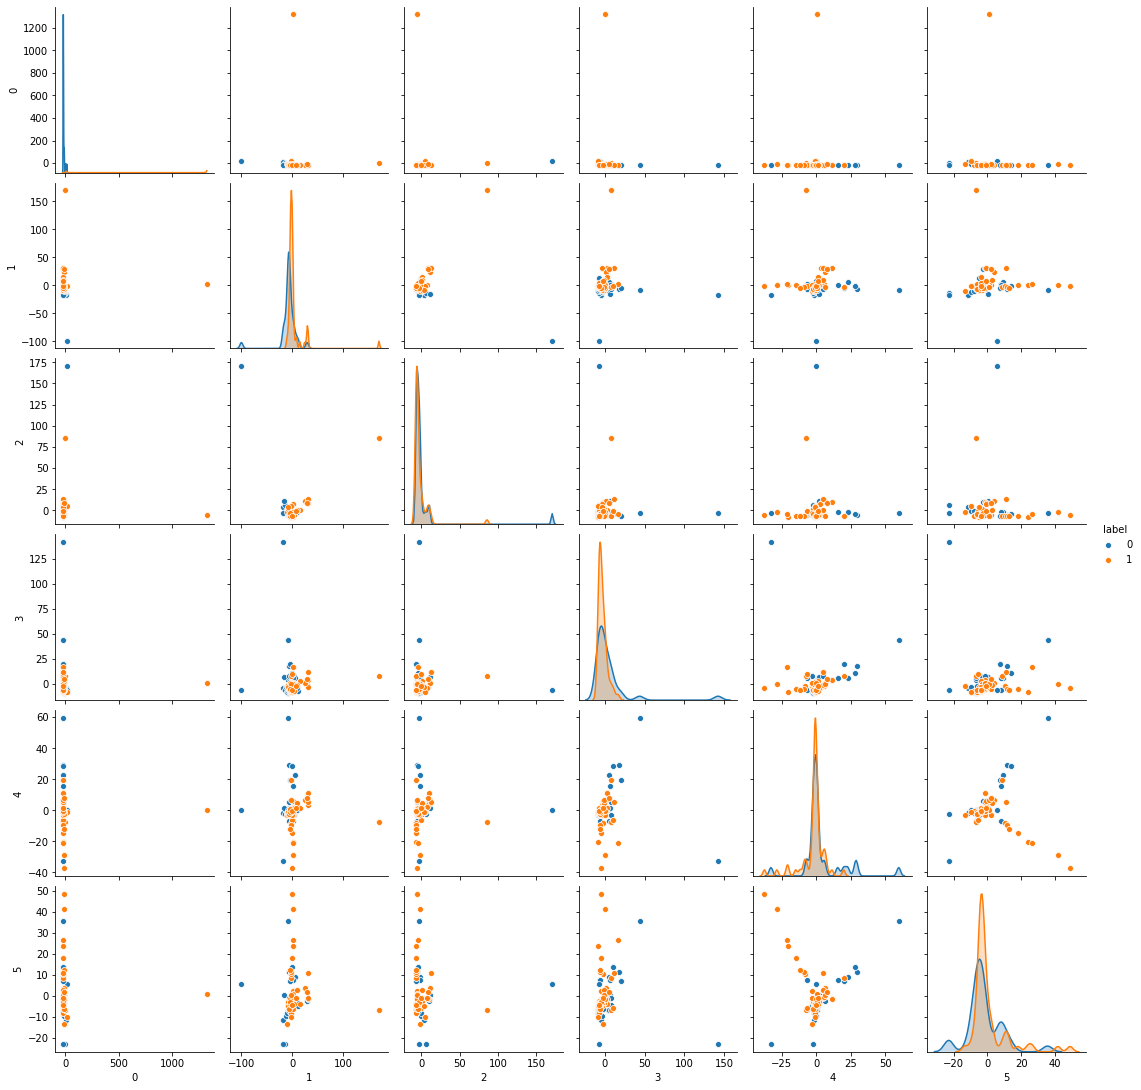

In [0]:
# Feature extraction
#x_train_trans, x_test_trans = train_pca(x_train_transformed, x_test_transformed, components=4)

pca = PCA(n_components=6)
# Fit the PCA model
pca.fit(x_train_transformed)
# Transform data
x_train_trans = pca.transform(x_train_transformed)

print(f'Size of x_train after pca: {x_train_trans.shape}')
#print(f'Size of x_test after pca: {x_test_trans.shape}')
print(f'Length of train labels: {len(y_train)}')
#print(f'Length of x_train after pca: {len(x_train_trans)}')

pca4_plot(x_train_trans, labels_train)


## Section 4: Training Classifiers

In this section ... are trained on the train set using sklearn. 

In [0]:
# Classifiers trained
classifiers = [
    KNeighborsClassifier(5),
    GaussianNB(),
    DecisionTreeClassifier()]
names_clf = ['KNeighborsClassifier', 'GaussianNB', 'DecisionTreeClassifier']

# Create empty dataframe for results
accuracy_scores = pd.DataFrame()

for num, clf in enumerate(classifiers):

    # Create pipeline
    #steps = [('imputation', KNNImputer(n_neighbors=5, weights='distance')),
         #('scaler', sklearn.preprocessing.StandardScaler()),
         # ('clf', clf)]
    steps = [('clf', clf)]
    pipeline = Pipeline(steps)

    # Use cross-validation 
    #kfold = sklearn.model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)
    kfold = KFold(n_splits=5)
    accuracy = cross_val_score(pipeline, x_train_transformed, y_train, scoring='accuracy',cv=kfold)
    auc = cross_val_score(pipeline, x_train_transformed, y_train, scoring='roc_auc',cv=kfold)

    # Add results to dataframe
    accuracy_scores[num] = accuracy

    print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2))
    print("AUC: %0.2f (+/- %0.2f)" % (auc.mean(), auc.std() * 2))

# Change column names to classifier name
accuracy_scores.columns = names_clf

print(accuracy_scores)

Accuracy: 0.78 (+/- 0.21)
AUC: 0.79 (+/- 0.22)
Accuracy: 0.63 (+/- 0.18)
AUC: 0.73 (+/- 0.20)
Accuracy: 0.81 (+/- 0.05)
AUC: 0.85 (+/- 0.10)
   KNeighborsClassifier  GaussianNB  DecisionTreeClassifier
0              0.789474    0.631579                0.789474
1              0.944444    0.611111                0.777778
2              0.666667    0.611111                0.833333
3              0.666667    0.500000                0.833333
4              0.833333    0.777778                0.833333


## Section 5: Performance Evaluation

Testing classifiers on test set. The following evaluation measures are evaluated:


*   Accuracy
*   F1-Score
*  AUC



In [0]:
# Metrics 

y_score = sklearn.model_selection.cross_val_predict(DecisionTreeClassifier(), x_test_transformed, y_test, method='predict_proba')
print(y_score)
curve = roc_curve_plot(y_test,y_score[:,1], GaussianNB)


In [96]:
## PERFORMANCE OF DIFFERENT CLASSIFIERS ON TRAINING SET ##

# Loop over different classifiers
classifiers = [KNeighborsClassifier(), sklearn.ensemble.RandomForestClassifier(), sklearn.svm.SVC()]

# Create emtpy dataframes for scores
accuracy_df = pd.DataFrame()
auc_df = pd.DataFrame()

for num, clf in enumerate(classifiers):
  
  # Create pipeline
  steps = [('imputation', KNNImputer(n_neighbors=5, weights='distance')),
           ('scaler', sklearn.preprocessing.RobustScaler()),
           ('PCA', PCA(n_components=6, whiten=True)),
           ('clf', clf)]
  pipeline = Pipeline(steps)
  pipeline.fit(data_train, labels_train)

  # Use repeated cross-validation 
  kfold = sklearn.model_selection.RepeatedKFold(n_splits=5, n_repeats=10, random_state=None)

  # Metric calculation
  accuracy = cross_val_score(pipeline, data_train, labels_train, scoring='accuracy',cv=kfold)
  auc = cross_val_score(pipeline, data_train, labels_train, scoring='roc_auc',cv=kfold)

  # Print results
  print("Accuracy: %0.2f (+/- %0.2f)" % (accuracy.mean(), accuracy.std() * 2))
  print("AUC: %0.2f (+/- %0.2f)" % (auc.mean(), auc.std() * 2))

  # Add scores to dataframe 
  accuracy_df[num] = accuracy
  auc_df[num] = auc

# Change column names to classifier name
names_clf = ["KNeighborsClassifier", "RandomForest", "SVM"]
accuracy_df.columns = names_clf
auc_df.columns = names_clf

print(accuracy_df.head())
print(auc_df.head())


Accuracy: 0.76 (+/- 0.18)
AUC: 0.79 (+/- 0.18)
Accuracy: 0.77 (+/- 0.15)
AUC: 0.82 (+/- 0.22)
Accuracy: 0.71 (+/- 0.21)
AUC: 0.78 (+/- 0.24)
   KNeighborsClassifier  RandomForest       SVM
0              0.842105      0.736842  0.684211
1              0.666667      0.611111  0.555556
2              0.666667      0.888889  0.833333
3              0.777778      0.777778  0.833333
4              0.888889      0.833333  0.666667
   KNeighborsClassifier  RandomForest       SVM
0              0.755556      0.931818  0.855556
1              0.729167      0.875000  0.787500
2              0.847222      0.826389  0.736111
3              0.857143      0.850000  0.750000
4              0.723077      0.769231  0.819444


The best performing classifier is RandomForest. This one is tested on the test set.

In [0]:
# Testing

data_test, labels_test = preprocessing(data_testing)

clf = sklearn.ensemble.RandomForestClassifier()
steps = [('imputation', KNNImputer(n_neighbors=5, weights='distance')),
           ('scaler', sklearn.preprocessing.RobustScaler()),
           ('PCA', PCA(n_components=6, whiten=True)),
           ('clf', clf)]
pipeline = Pipeline(steps)
pipeline.fit(data_train, labels_train)

# Metrics 
y_score = sklearn.model_selection.cross_val_predict(pipeline, data_test, labels_test, method='predict_proba')
curve = roc_curve_plot(labels_test, y_score[:,1], RandomForestClassifier)


TypeError: ignored